In [1]:
from functions.functions import *
import warnings
import soundfile
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # This is to avoid the memory fragmentation

# Retina display
%config InlineBackend.figure_format = 'retina'
print(device)

CUDA is available. Using GPU.
cuda


In [3]:
img_path = "Lenna.png"
if not (os.path.exists(img_path)):
  !wget "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png" -O "Lenna.png"
original_img = load_and_preprocess_image(img_path, top = 0 , left = 0 , crop_size=512)


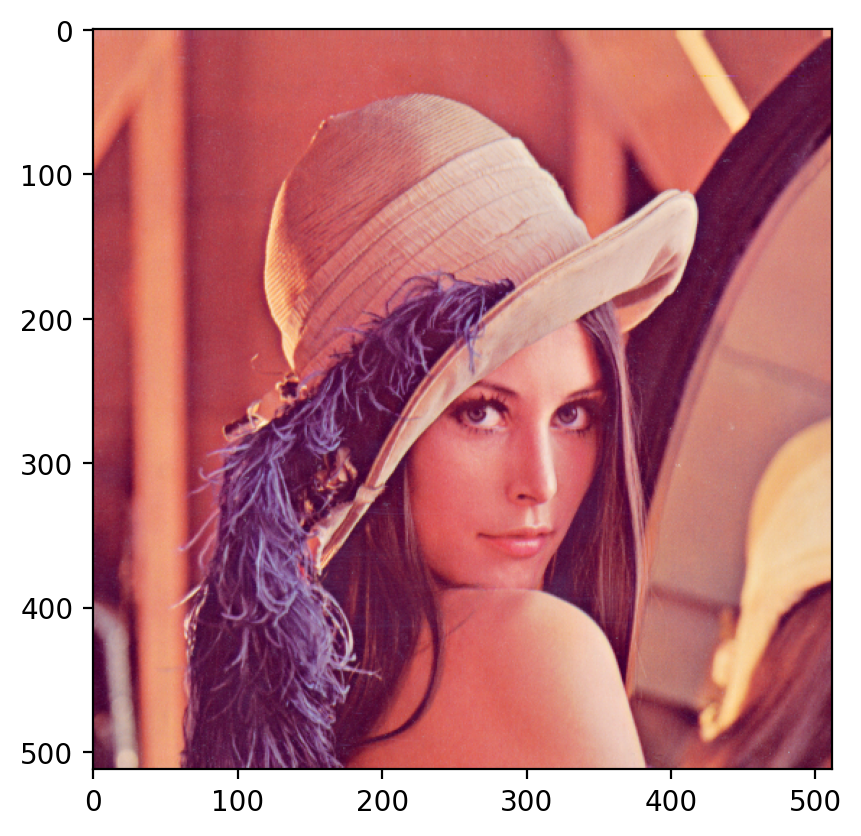

In [4]:
plt.imshow(rearrange(original_img, 'c h w -> h w c').numpy())

In [5]:
X, Y = (create_coordinate_map(original_img))
scaled_X, scaler = scale_coordinates(X)

In [6]:
X_rff = create_rff_features(scaled_X, 30000, 0.008).to(device)

In [7]:
net = LinearModel(X_rff.shape[1], 3).to(device)
train(net, 0.005, X_rff.to(device), Y.to(device), 2000)

Epoch 0 loss: 0.302400
Epoch 100 loss: 0.036331


Epoch 200 loss: 0.007868
Epoch 300 loss: 0.004016
Epoch 400 loss: 0.002700
Epoch 500 loss: 0.002000
Epoch 600 loss: 0.001600
Epoch 700 loss: 0.001368
Epoch 800 loss: 0.001234
Epoch 900 loss: 0.001156
Epoch 1000 loss: 0.001112
Epoch 1100 loss: 0.001086
Epoch 1200 loss: 0.001071
Epoch 1300 loss: 0.001063
Epoch 1400 loss: 0.001057
Epoch 1500 loss: 0.001053
Epoch 1600 loss: 0.001051
Epoch 1700 loss: 0.001049
Epoch 1800 loss: 0.001048
Epoch 1900 loss: 0.001046


0.001045301789417863

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


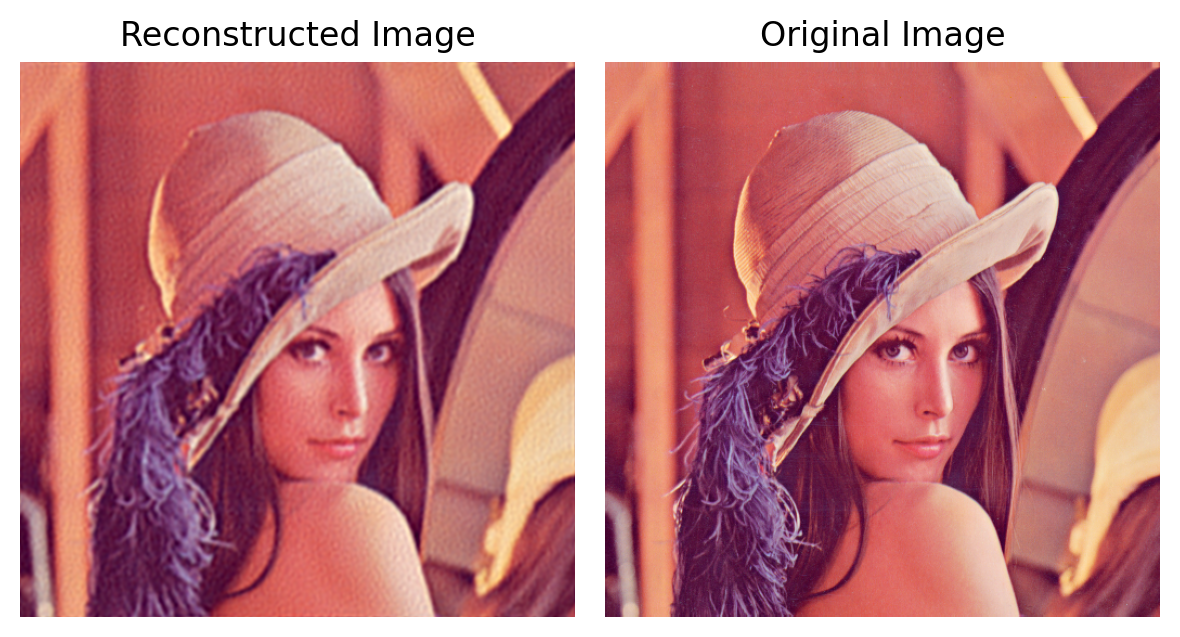

In [8]:
pred_image = plot_reconstructed_and_original_image(original_img, net, X_rff, title="")

In [14]:
# Reshape pred_image to the same shape as Y.
metrics = calculate_metrics(Y.to(device), pred_image.reshape(-1, 3).to(device))
print(f"RMSE: {metrics[0]:.6f}, PSNR: {metrics[1]:.6f}")
del(X_rff)

RMSE: 0.032331, PSNR: 29.807625


In [15]:
from IPython.display import Audio
import torchaudio
org_sound_path = 'ES335-MLAssignment2/trimmed-pokemon-22k.wav'
Audio(org_sound_path)

In [16]:
audio, sr = torchaudio.load("./"+org_sound_path)
print(f"Sampling frequency: {sr} Hz")
print(audio.shape)
audio = audio[0]

Sampling frequency: 22050 Hz
torch.Size([2, 394584])


In [17]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

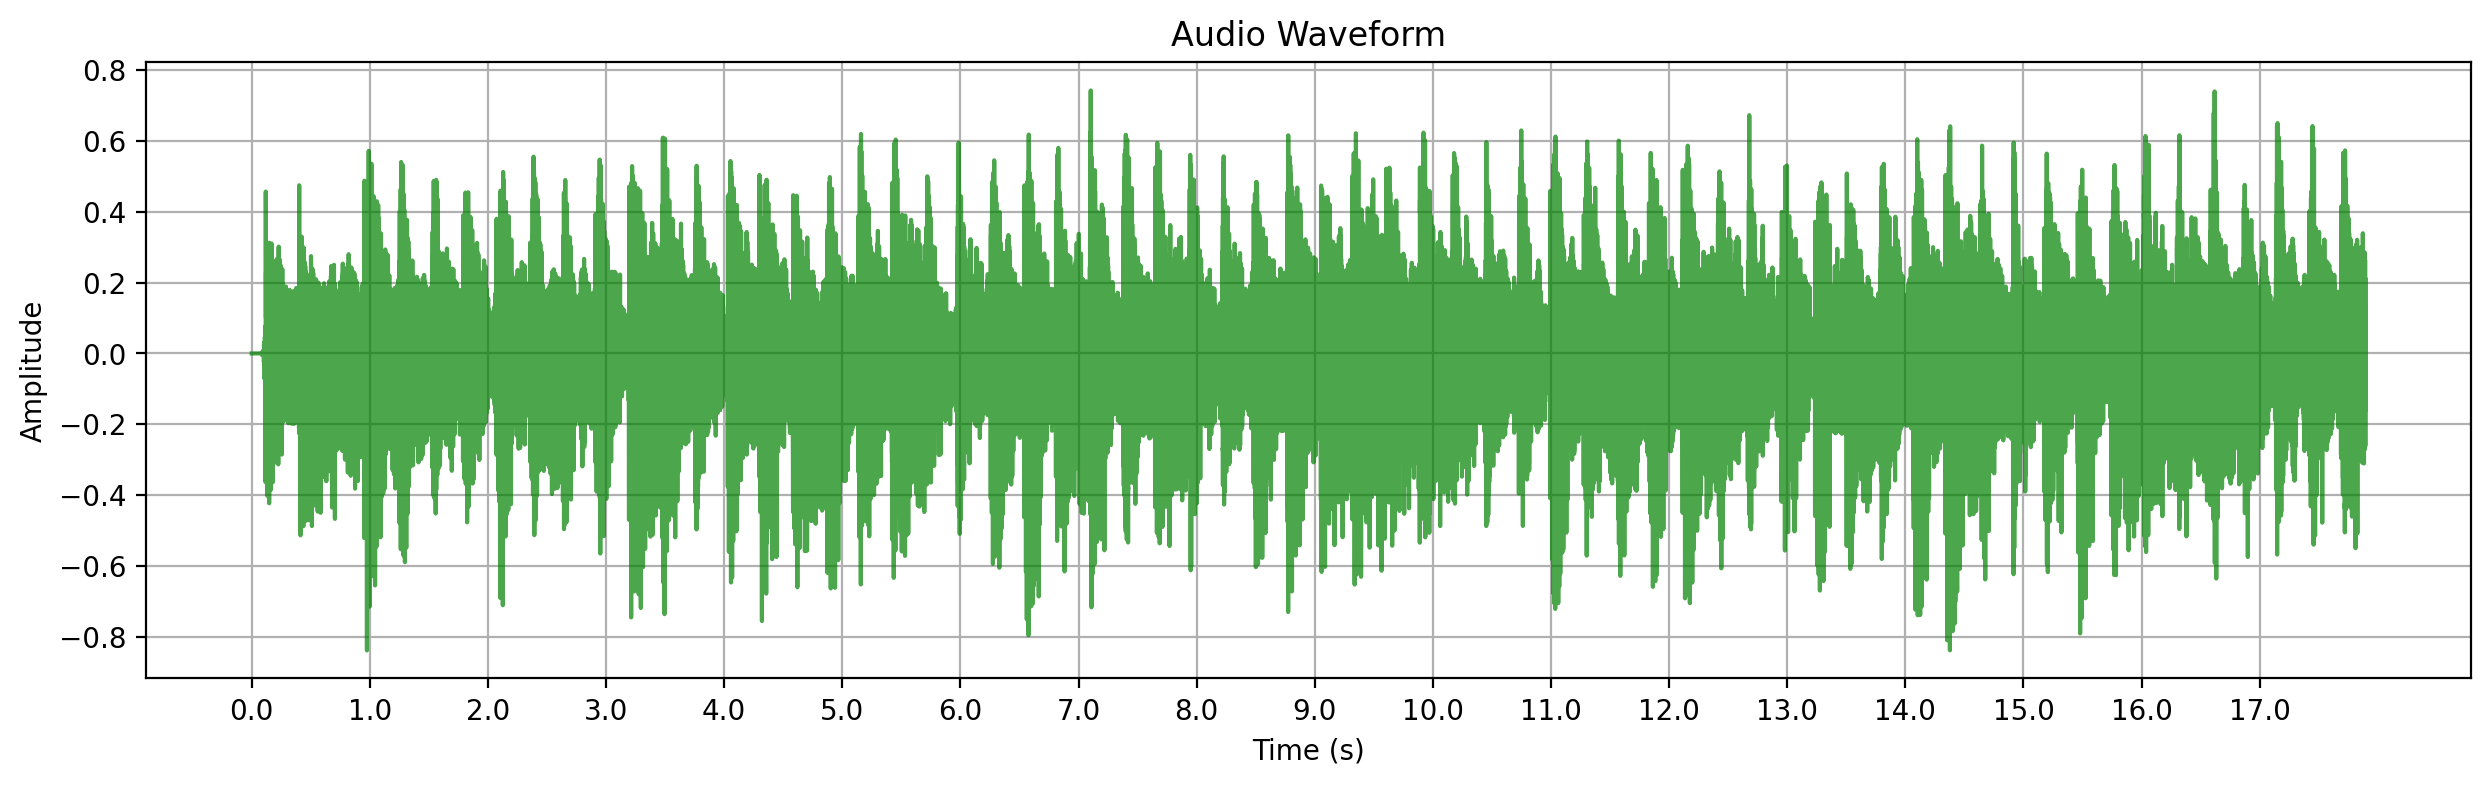

In [18]:
audio_plot(audio, sr, 'green', 'Audio Waveform')

In [19]:
audio_tr = audio[:5*sr]
X = torch.arange(0, len(audio_tr)).unsqueeze(1).float()
m = X.max()
X = X / m * 200 - 100
print(X.shape)
print(X)

torch.Size([110250, 1])
tensor([[-100.0000],
        [ -99.9982],
        [ -99.9964],
        ...,
        [  99.9964],
        [  99.9982],
        [ 100.0000]])


In [20]:
Audio(audio_tr, rate = sr)

In [21]:
num_features = 30000
sigma = 0.008
X_rff = create_rff_features(X, num_features, sigma).to(device)
X_rff.shape

torch.Size([110250, 30000])

In [22]:
net = LinearModel(X_rff.shape[1], 1)
net.to(device)
X_rff = X_rff.to(device)
audio_tr = audio_tr.view(-1, 1).to(device)
train(net, 0.001, X_rff, audio_tr, 2000)

Epoch 0 loss: 0.021264


Epoch 100 loss: 0.009390
Epoch 200 loss: 0.005484
Epoch 300 loss: 0.003618
Epoch 400 loss: 0.002590
Epoch 500 loss: 0.001976
Epoch 600 loss: 0.001590
Epoch 700 loss: 0.001339
Epoch 800 loss: 0.001170
Epoch 900 loss: 0.001053
Epoch 1000 loss: 0.000972
Epoch 1100 loss: 0.000914
Epoch 1200 loss: 0.000871
Epoch 1300 loss: 0.000839
Epoch 1400 loss: 0.000814
Epoch 1500 loss: 0.000794
Epoch 1600 loss: 0.000779
Epoch 1700 loss: 0.000766
Epoch 1800 loss: 0.000755
Epoch 1900 loss: 0.000746


0.0007379826274700463

In [23]:
net.eval()
with torch.no_grad():
  pred_audio = net(X_rff).cpu().numpy().flatten()
  del(X_rff)

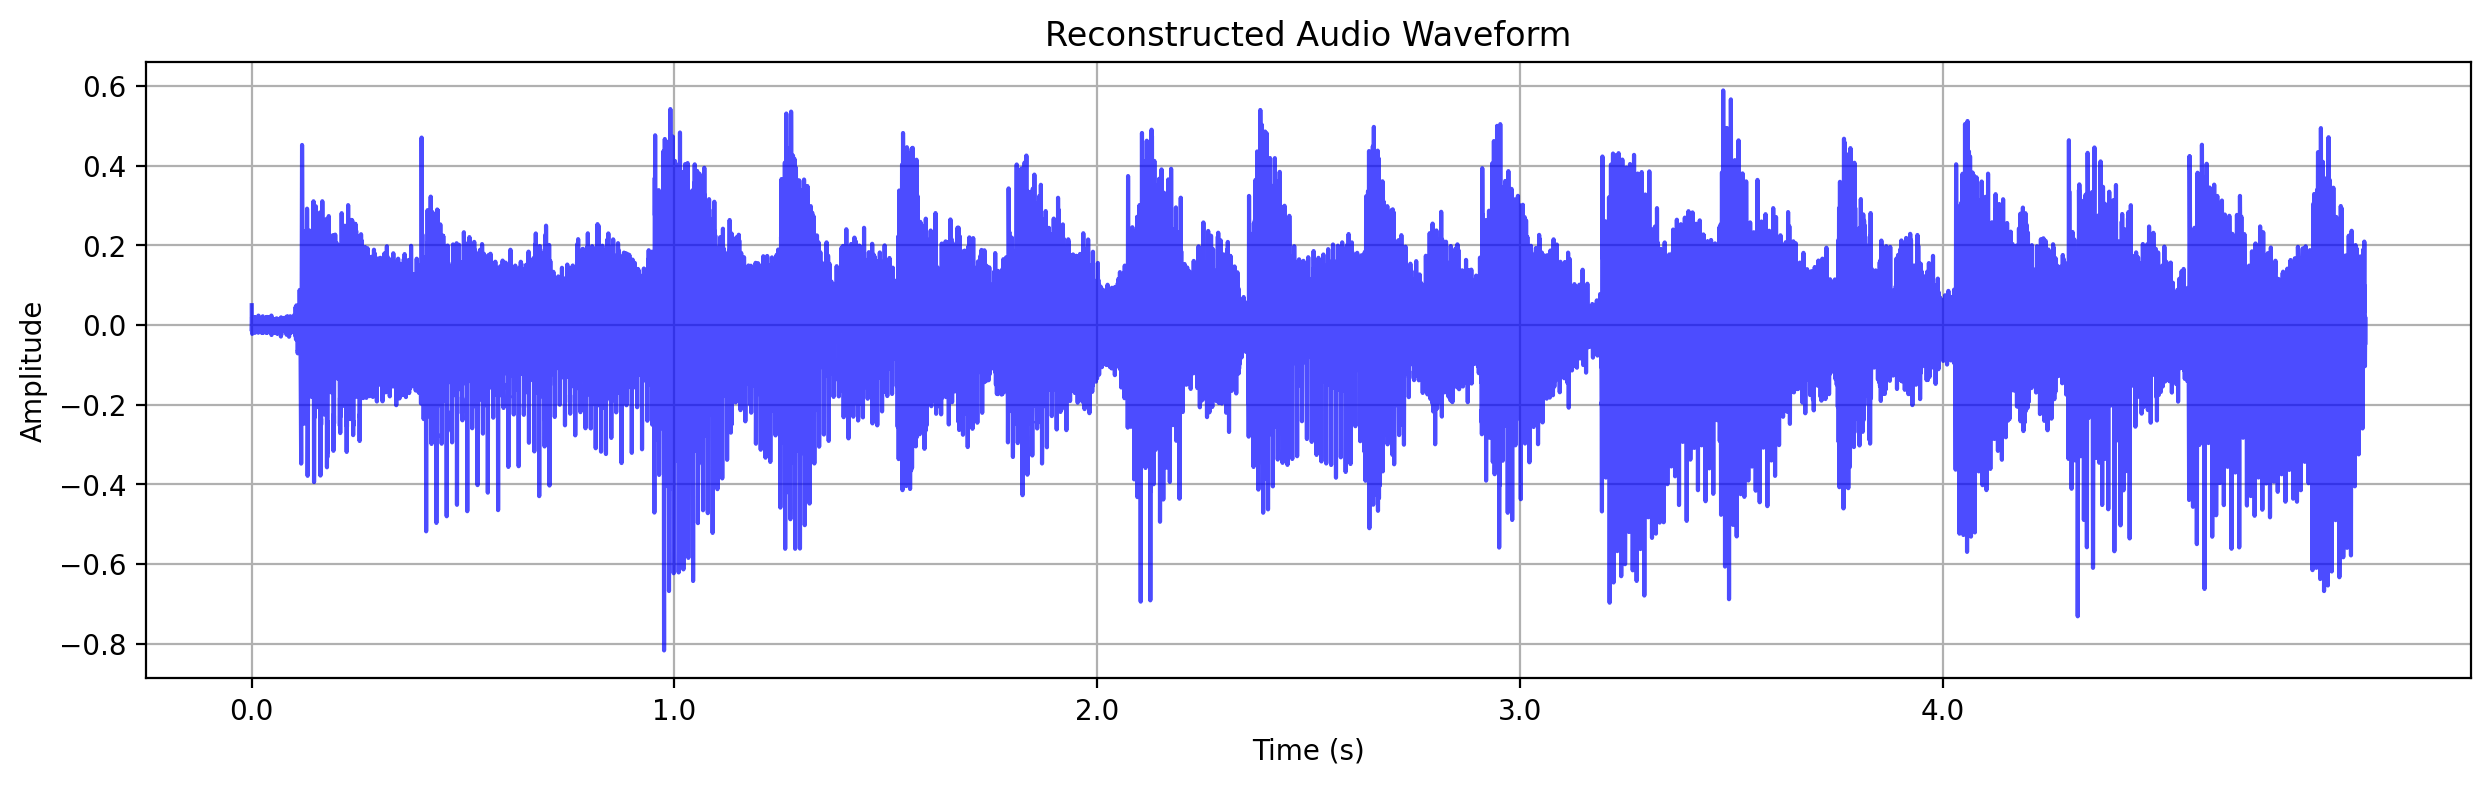

In [24]:
display(Audio(pred_audio, rate = sr))
audio_plot(pred_audio, sr, 'blue', 'Reconstructed Audio Waveform')
import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sr)

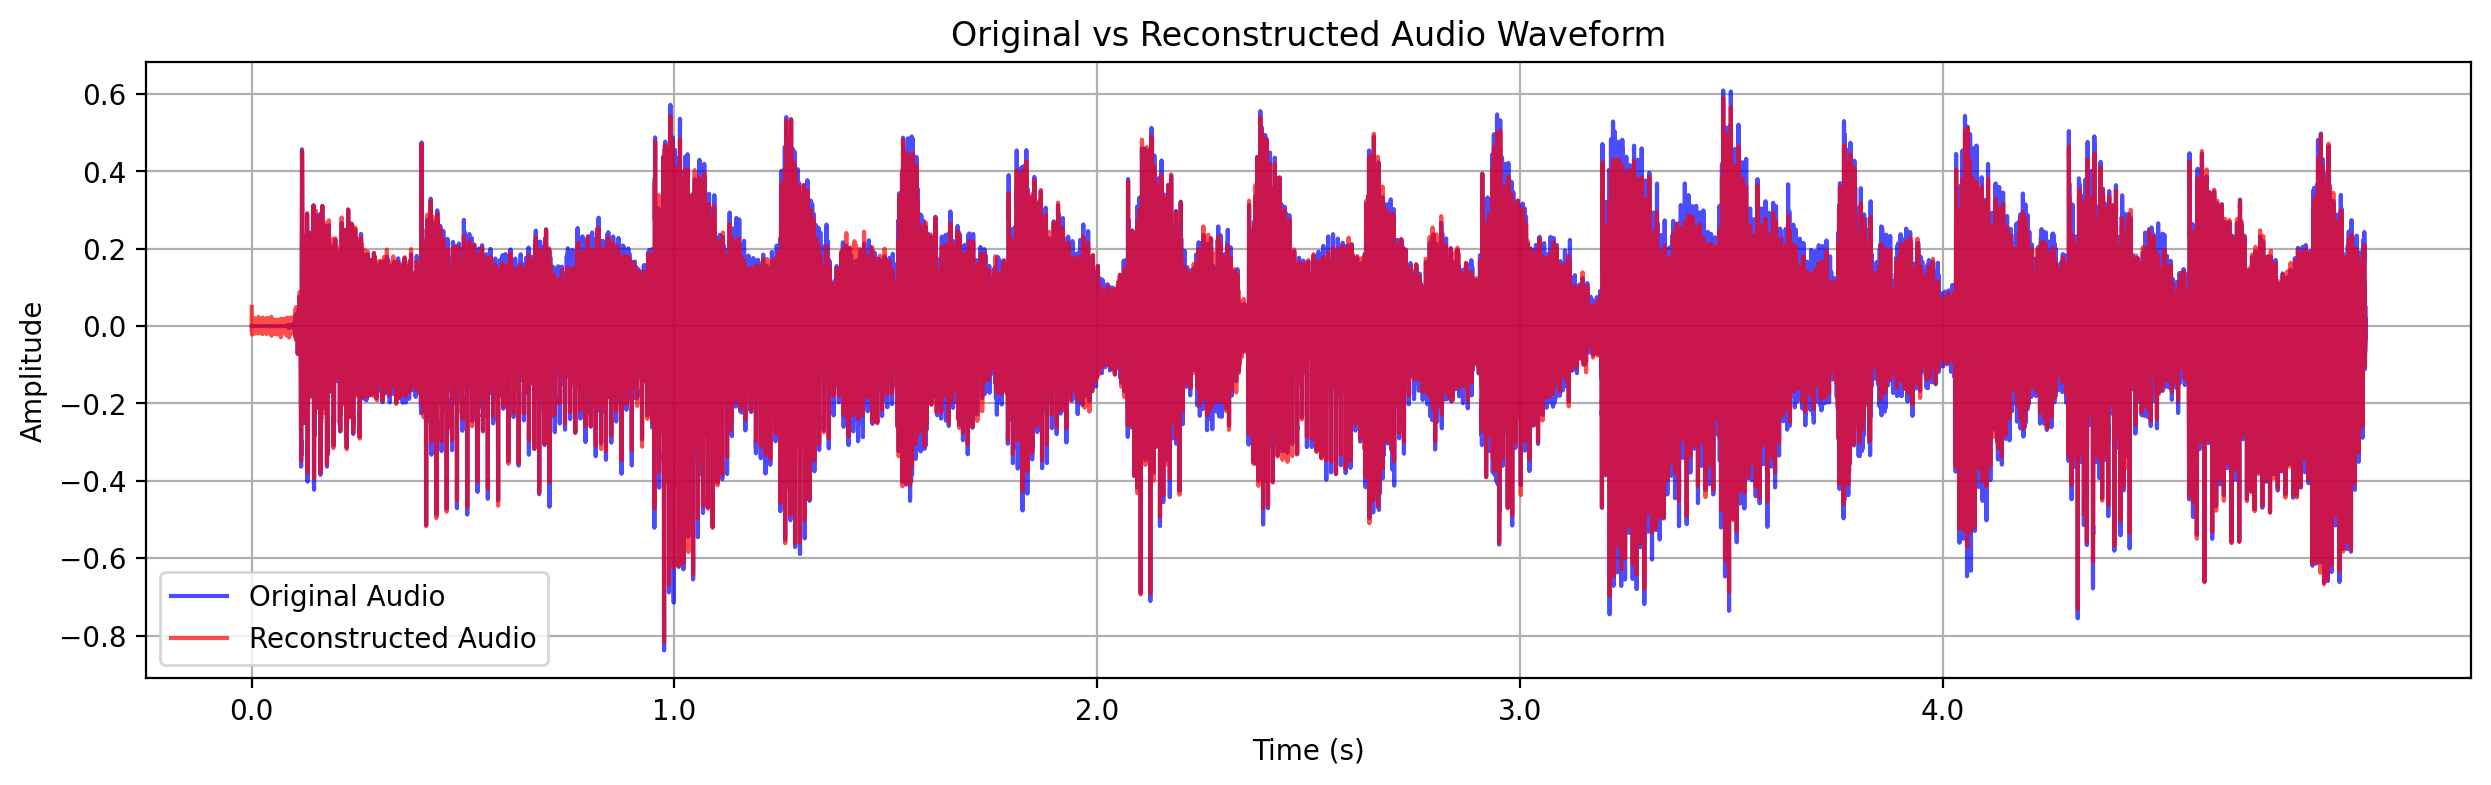

In [25]:
plt.figure(figsize=(15, 4))
plt.plot(audio_tr.cpu(), color = 'blue', alpha = 0.7, label = 'Original Audio')
plt.plot(pred_audio, color = 'red', alpha = 0.7, label = 'Reconstructed Audio')
plt.xticks(np.arange(0, audio_tr.shape[0], sr), np.arange(0, audio_tr.shape[0] / sr, 1))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original vs Reconstructed Audio Waveform')
plt.grid()
plt.legend()
plt.show()

In [42]:
device = torch.device('cpu')
pred_audio = torch.tensor(pred_audio).to(device)
audio_tr = audio_tr.to(device)
snr = torch.mean(audio_tr**2) / torch.mean((audio_tr - torch.tensor(pred_audio)).view(-1, 1))**2
snr = 10 * torch.log10(snr)
rmse = torch.sqrt(torch.mean((audio_tr - torch.tensor(pred_audio).view(-1, 1))**2))
print(f"SNR: {snr:.6f}, RMSE: {rmse:.6f}")

SNR: 156.199814, RMSE: 0.027164


In [44]:
import joblib
joblib.dump(net, 'ES335-MLAssignment2/audio_net.pkl')
net = joblib.load('ES335-MLAssignment2/audio_net.pkl')